In [ ]:
'''
this code is based on 
https://github.com/tensorflow/compression/blob/master/models/toy_sources/toy_sources.ipynb
please refer to this git repo for tensorflow-compression package installation/usage
'''

'''
this code aims to compress modified MNIST images
    - each image is enlarged to 40x40 and subject to salt and pepper noise
'''

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import numpy as np
import os
import timeit

2023-01-24 18:43:35.132328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:43:35.640854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chiu/.local/lib/python3.10/site_packages/tensorrt:/usr/local/cuda-12.0/targets/x86_64-linux/lib:/usr/local/cuda-12.0/lib64:/usr/local/cuda-12.0/targets/x86_64-linux/lib:
2023-01-24 18:43:35.640899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file

In [2]:
# GPU usage setting for TensorFlow
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 11GB of memory on the first GPU
#     try:
#         tf.config.set_logical_device_configuration(
#         gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-24 18:43:36.574414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:43:36.609906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:43:36.610025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# encoding and decoding 

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          5000, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((10, 10, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [4]:
batch_size=200

# image parameters
ref_len = 40
ref_shape = [40,40]

# setting sigma map
sigma_list_temp = [0.,5.,10.]
sigma_no_arg1 = 2*np.ones((13,13),dtype=int)
sigma_no_arg2 = 1*np.ones((13,14),dtype=int)
sigma_no_arg3 = 0*np.ones((14,14),dtype=int)
sigma_no_args_line1 = (sigma_no_arg1,sigma_no_arg2,sigma_no_arg1)
sigma_no_args_line2 = (sigma_no_arg2.T,sigma_no_arg3,sigma_no_arg2.T)
sigma_no_list = np.concatenate((np.concatenate((sigma_no_args_line1),axis=1),
                            np.concatenate((sigma_no_args_line2),axis=1),
                            np.concatenate((sigma_no_args_line1),axis=1)),axis=0)
sigma_no_list_tf = tf.convert_to_tensor(sigma_no_list,tf.int32)

# setting pooling PMF
pmf_k_list_temp = []
pmf_list_temp = []
for sigma_no_temp in range(len(sigma_list_temp)):
    sigma = sigma_list_temp[sigma_no_temp]
    if sigma == 0:
        pmf_k_list_temp.append(0)
        pmf_list_temp.append(tf.constant([[1.]]))
    else:
        pmf_k_temp = int(np.ceil(max(0,-sigma*np.log((np.exp(1/sigma)+1)/4))))
        pmf_k_list_temp.append(pmf_k_temp)
        pmf_temp = tf.squeeze(tf.convert_to_tensor([[[((tf.exp(1/sigma)-1)/(tf.exp(1/sigma)+1))*\
                                               tf.exp(-(tf.abs(tf.cast(i_ref_p-0,dtype=tf.float32))+\
                                                        tf.abs(tf.cast(j_ref_p-0,dtype=tf.float32)))/sigma)/\
                                               (4*tf.reduce_max(tf.convert_to_tensor([tf.constant(1/4),\
                                                   tf.abs(tf.cast(i_ref_p-0,dtype=tf.float32))+\
                                                     tf.abs(tf.cast(j_ref_p-0,dtype=tf.float32))])))]\
                                          for j_ref_p in range(-pmf_k_temp,pmf_k_temp+1)]\
                                          for i_ref_p in range(-pmf_k_temp,pmf_k_temp+1)]))
        pmf_temp = pmf_temp/tf.reduce_sum(pmf_temp)
        pmf_list_temp.append(pmf_temp)
pmf_k_list = tf.convert_to_tensor(pmf_k_list_temp)
pmf_list = tf.ragged.stack(pmf_list_temp)

2023-01-24 18:43:36.638203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:43:36.638670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:43:36.638894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:43:36.639065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [5]:
#feature space: pixel value (x & x_tilde) and dilated pixel values (x_maxpool && x_tilde_maxpool)

@tf.function(reduce_retracing=True)
def wass_inner_j(x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,j_ref,diff_temp_i):
    sigma_no = sigma_no_list_tf[i_ref,j_ref]
    pmf_k = pmf_k_list[sigma_no]
    pmf = pmf_list[sigma_no].to_tensor()

    # calculating 2-wasserstein distance between pixel values
    x_current = tf.reshape(x[:,tf.reduce_max([0,i_ref-pmf_k]):tf.reduce_min([ref_len,i_ref+pmf_k+1]),\
                            tf.reduce_max([0,j_ref-pmf_k]):tf.reduce_min([ref_len,j_ref+pmf_k+1]),0],[batch_size,-1])
    x_tilde_current = tf.reshape(x_tilde[:,tf.reduce_max([0,i_ref-pmf_k]):tf.reduce_min([ref_len,i_ref+pmf_k+1]),\
                            tf.reduce_max([0,j_ref-pmf_k]):tf.reduce_min([ref_len,j_ref+pmf_k+1]),0],[batch_size,-1])
    pmf_current = tf.tile(tf.expand_dims(tf.reshape(pmf[tf.reduce_max([0,pmf_k-i_ref]):\
                             tf.reduce_min([pmf_k-i_ref+ref_len,2*pmf_k+1]),tf.reduce_max([0,pmf_k-j_ref]):\
                             tf.reduce_min([pmf_k-j_ref+ref_len,2*pmf_k+1])],[-1]),0),[batch_size,1])
    pmf_current = pmf_current/tf.reduce_sum(pmf_current)
    x_sorter = tf.argsort(x_current)
    x_tilde_sorter = tf.argsort(x_tilde_current)
    x_current = tf.experimental.numpy.take_along_axis(x_current,x_sorter,axis=1)
    x_tilde_current = tf.experimental.numpy.take_along_axis(x_tilde_current,x_tilde_sorter,axis=1)
    pmf_x = tf.experimental.numpy.take_along_axis(pmf_current,x_sorter,axis=1)
    pmf_x_tilde = tf.experimental.numpy.take_along_axis(pmf_current,x_tilde_sorter,axis=1)
    pmf_x_cumsum = tf.cumsum(pmf_x,axis=1)
    pmf_x_tilde_cumsum = tf.cumsum(pmf_x_tilde,axis=1)
    pmf_total = tf.sort(tf.concat((pmf_x_cumsum,pmf_x_tilde_cumsum),axis=1),axis=1)
    x_indx = tf.searchsorted(pmf_x_cumsum,pmf_total)
    x_tilde_indx = tf.searchsorted(pmf_x_tilde_cumsum,pmf_total)
    x_repeat = tf.experimental.numpy.take_along_axis(x_current,x_indx,axis=1)
    x_tilde_repeat = tf.experimental.numpy.take_along_axis(x_tilde_current,x_tilde_indx,axis=1)
    pmf_total = tf.pad(pmf_total,[[0,0],[1,0]],'CONSTANT')
    pmf_diff = pmf_total[:,1:] - pmf_total[:,:-1]
    diff_temp_temp = tf.reduce_sum(pmf_diff*(x_repeat-x_tilde_repeat)**2,axis=1)

    # calculating 2-wasserstein distance between dilated values
    x_mp_current = tf.reshape(x_maxpool[:,tf.reduce_max([0,i_ref-pmf_k]):tf.reduce_min([ref_len,i_ref+pmf_k+1]),\
                            tf.reduce_max([0,j_ref-pmf_k]):tf.reduce_min([ref_len,j_ref+pmf_k+1]),0],[batch_size,-1])
    x_tilde_mp_current = tf.reshape(x_tilde_maxpool[:,tf.reduce_max([0,i_ref-pmf_k]):\
                            tf.reduce_min([ref_len,i_ref+pmf_k+1]),tf.reduce_max([0,j_ref-pmf_k]):\
                            tf.reduce_min([ref_len,j_ref+pmf_k+1]),0],[batch_size,-1])
    x_mp_sorter = tf.argsort(x_mp_current)
    x_tilde_mp_sorter = tf.argsort(x_tilde_mp_current)
    x_mp_current = tf.experimental.numpy.take_along_axis(x_mp_current,x_mp_sorter,axis=1)
    x_tilde_mp_current = tf.experimental.numpy.take_along_axis(x_tilde_mp_current,x_tilde_mp_sorter,axis=1)
    pmf_x_mp = tf.experimental.numpy.take_along_axis(pmf_current,x_mp_sorter,axis=1)
    pmf_x_tilde_mp = tf.experimental.numpy.take_along_axis(pmf_current,x_tilde_mp_sorter,axis=1)
    pmf_x_mp_cumsum = tf.cumsum(pmf_x_mp,axis=1)
    pmf_x_tilde_mp_cumsum = tf.cumsum(pmf_x_tilde_mp,axis=1)
    pmf_mp_total = tf.sort(tf.concat((pmf_x_mp_cumsum,pmf_x_tilde_mp_cumsum),axis=1),axis=1)
    x_mp_indx = tf.searchsorted(pmf_x_mp_cumsum,pmf_mp_total)
    x_tilde_mp_indx = tf.searchsorted(pmf_x_tilde_mp_cumsum,pmf_mp_total)
    x_mp_repeat = tf.experimental.numpy.take_along_axis(x_mp_current,x_mp_indx,axis=1)
    x_tilde_mp_repeat = tf.experimental.numpy.take_along_axis(x_tilde_mp_current,x_tilde_mp_indx,axis=1)
    pmf_mp_total = tf.pad(pmf_mp_total,[[0,0],[1,0]],'CONSTANT')
    pmf_mp_diff = pmf_mp_total[:,1:] - pmf_mp_total[:,:-1]
    diff_mp_temp_temp = tf.reduce_sum(pmf_mp_diff*(x_mp_repeat-x_tilde_mp_repeat)**2,axis=1)
    
    j_ref = tf.add(j_ref,1)
    diff_temp_i = tf.reduce_sum([diff_temp_i,diff_temp_temp,diff_mp_temp_temp],axis=0)
    return x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,j_ref,diff_temp_i

@tf.function(reduce_retracing=True)
def wass_inner_i(x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,diff):
    j_ref = tf.constant(0)
    diff_temp_i = tf.zeros([batch_size],dtype=tf.float32)
    condition_j = lambda x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,j_ref,diff_temp_i: tf.less(j_ref,40)
    x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,j_ref,diff_temp_i = tf.while_loop(condition_j,wass_inner_j,\
                                            loop_vars=[x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,j_ref,diff_temp_i])
    i_ref = tf.add(i_ref,1)
    diff = tf.reduce_sum([diff,diff_temp_i],axis=0)
    return x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,diff

In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 40, 40, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # distortion
    batch_size=200
    # image parameters
    ref_shape = [40,40]
    ref_len = 40
    # feature calc
    x_maxpool = tf.nn.max_pool(x,ksize=2,strides=1,padding='SAME')
    x_tilde_maxpool = tf.nn.max_pool(x_tilde,ksize=2,strides=1,padding='SAME')
    # distortion calc
    i_ref = tf.constant(0)
    diff = tf.zeros([batch_size],dtype=tf.float32)
    condition_i = lambda x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,diff: tf.less(i_ref,40)
    x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,diff = tf.while_loop(condition_i,wass_inner_i,\
                                                        loop_vars=[x,x_tilde,x_maxpool,x_tilde_maxpool,i_ref,diff])
    distortion = diff

    return dict(rate=rate, distortion=distortion)

In [7]:
# data: pre-processed MNIST, enlarged to 40x40 and added salt and pepper noise

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './mnist_psnoise',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=1,
    image_size=(40,40),
    shuffle=True,
    seed=7,
    validation_split=1/7,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './mnist_psnoise',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=1,
    image_size=(40,40),
    shuffle=True,
    seed=7,
    validation_split=1/7,
    subset='validation'
)

Found 70000 files belonging to 11 classes.
Using 60000 files for training.
Found 70000 files belonging to 11 classes.
Using 10000 files for validation.


In [8]:
checkpoint_path = "./saved_weights_ot_whileloop_mp/pyfunc-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   save_freq='epoch')

In [9]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=800):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda)
  )
  return trainer

In [10]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(200),
      epochs=20,
      validation_data=validation_dataset.map(add_rd_targets).batch(200).cache(),
      validation_freq=1,
      verbose=1,
      callbacks=[callback]
  )
  return trainer

trainer = train_mnist_model(lmbda=500000)

Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-24 18:43:46.883123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-01-24 18:43:47.409772: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa8c8080560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-24 18:43:47.409792: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-01-24 18:43:47.413057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-24 18:43:47.498140: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - ETA: 0s - loss: 318196.8438 - distortion_loss: 0.6332 - rate_loss: 1600.3633 - distortion_pass_through_loss: 0.6332 - rate_pass_through_loss: 1600.3632


Epoch 1: saving model to ./saved_weights_ot_whileloop_mp/pyfunc-0001.ckpt
300/300 [==============================] - 1003s 3s/step - loss: 318196.8438 - distortion_loss: 0.6332 - rate_loss: 1600.3633 - distortion_pass_through_loss: 0.6332 - rate_pass_through_loss: 1600.3632 - val_loss: 217932.8281 - val_distortion_loss: 0.4326 - val_rate_loss: 1637.5907 - val_distortion_pass_through_loss: 0.4326 - val_rate_pass_through_loss: 1637.5906
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 199870.5625 - distortion_loss: 0.3963 - rate_loss: 1707.7600 - distortion_pass_through_loss: 0.3963 - rate_pass_through_loss: 1707.7600
Epoch 2: saving model to ./saved_weights_ot_whileloop_mp/pyfunc-0002.ckpt
300/300 [==============================] - 994s 3s/step - loss: 199870.5625 - distortion_loss: 0.3963 - rate_loss: 1707.7600 - distortion_pass_through_loss: 0.3963 - rate_pass_through_loss: 1707.7600 - val_loss: 185791.2969 - val_distortion_loss: 0.3680 - val_rate_loss: 1773.1656

In [ ]:
trainer.summary()

In [21]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.squeeze(x)
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.zeros((40, 7), tf.float32),
        tf.squeeze(originals[i]),
        tf.zeros((40, 6), tf.float32),
        tf.squeeze(tf.cast(reconstructions[i],tf.float32)),
        tf.zeros((40, 7), tf.float32),
    ], 1)
    axes[i].imshow(image,vmin=0,vmax=255)
#     axes[i].plot([13,13],[0,40],color="white", linewidth=1)
#     axes[i].plot([28,28],[0,40],color="white", linewidth=1)
#     axes[i].plot([0,40],[13,13],color="white", linewidth=1)
#     axes[i].plot([0,40],[28,28],color="white", linewidth=1)
#     axes[i].plot([74,74],[0,40],color="white", linewidth=1)
#     axes[i].plot([88,88],[0,40],color="white", linewidth=1)
#     axes[i].plot([60,101],[13,13],color="white", linewidth=1)
#     axes[i].plot([60,101],[28,28],color="white", linewidth=1)
#     axes[i].text(
#         .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
#         ha="center", va="top", color="white", fontsize="small",
#         transform=axes[i].transAxes)
#     axes[i].text(
#         .5, .5, f"{entropies[i]:0.2f} bits",
#         ha="center", va="top", color="white", fontsize="small",
#         transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  fig.savefig('ot+whileloop+mp_lmbda_500k_ltdim_800_noword_3.pdf')

compressor, decompressor = make_mnist_codec(trainer)

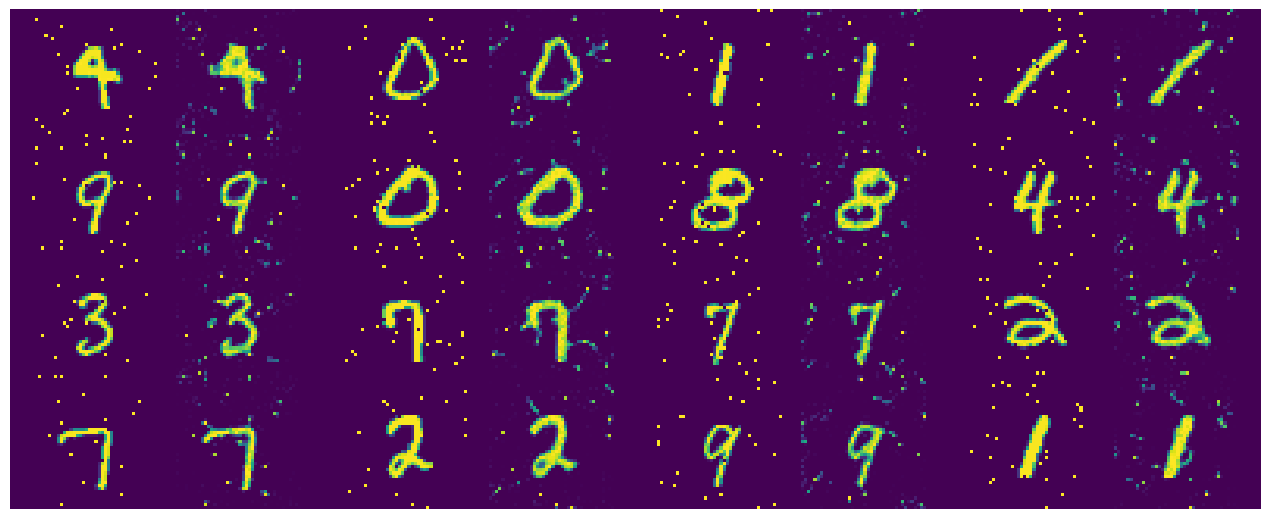

In [22]:
(originals, _), = validation_dataset.batch(16).skip(10).take(1)

strings, entropies = compressor(originals)

reconstructions = decompressor(strings)

display_digits(originals, strings, entropies, reconstructions)